In this notebook, we run a numerical simulation using the SIR equation:

$$s'=-\gamma si$$
$$i'=\mu si-\alpha i$$
$$r'=\alpha i$$

We then train the ODESolver model on the SEIR equation:

$$s'=-\gamma si$$
$$e'=\gamma si - \mu e$$
$$i'=\mu e-\alpha i$$
$$r'=\alpha i$$

The parameters we're estimating are: $\gamma, \mu, \alpha$

In [1]:
import sys
import torch

try:
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset
except:
    sys.path.append("../../../")
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset

import matplotlib.pyplot as plt

In [2]:
# SIR equations
dt = 0.01

def s_prime(prev_val, coeffs):
    return - coeffs["g"]*prev_val["s"]*prev_val["i"]

def i_prime(prev_val, coeffs):
    return coeffs["m"]*prev_val["s"]*prev_val["i"] - coeffs["a"]*prev_val["i"]

def r_prime(prev_val, coeffs):
    return coeffs["a"]*prev_val["i"]

ode = {"s": s_prime, "i": i_prime, "r": r_prime}

# Initial conditions [0,0,0]
ode_init = {"s": 0.1, "i": 0.2, "r": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "g": 0.3, "m": 0.2}


# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [3]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=torch.optim.SGD,
    optimizer_args={"lr": 0.01}
)

result = ode_solver(1000)

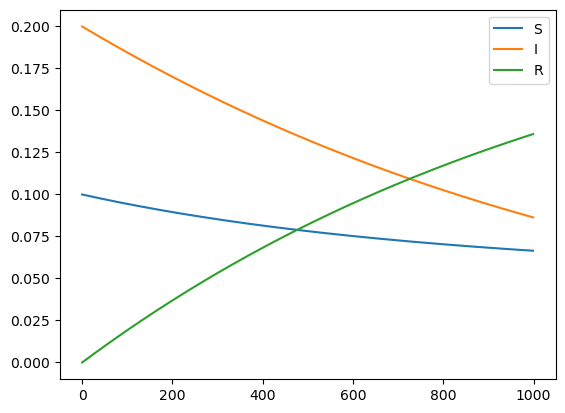

In [4]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(result_np[:,0])
plt.plot(result_np[:,1])
plt.plot(result_np[:,2])

plt.legend(["S", "I", "R"])

plt.show()

# Runge-Kutta method for training

In [5]:
# SEIR equations
dt = 0.01

def s_prime(prev_val, coeffs):
    return - coeffs["g"]*prev_val["s"]*prev_val["i"]

def e_prime(prev_val, coeffs):
    return coeffs["g"]*prev_val["s"]*prev_val["i"] - coeffs["m"]*prev_val["e"]

def i_prime(prev_val, coeffs):
    return coeffs["m"]*prev_val["e"] - coeffs["a"]*prev_val["i"]

def r_prime(prev_val, coeffs):
    return coeffs["a"]*prev_val["i"]

ode = {"s": s_prime, "e": e_prime, "i": i_prime, "r": r_prime}

# Initial conditions [0,0,0]
ode_init = {"s": 0.1, "e": 0., "i": 0.2, "r": 0}

# Constants (Parameters)
ode_train_coeffs = {"a": torch.rand(()), "g": torch.rand(()), "m": torch.rand(())}

In [14]:
ode_solver_train = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="rk4",
    outvar=["s","i","r"],
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": 0.05},
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_args={"milestones": [5],"gamma": 0.2}
)

/Users/marty/Documents/GitHub/torchTS/examples/ode/SEIR/../../../torchts/nn/models/ode.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_parameter(name, nn.Parameter(torch.tensor(value)))


In [16]:
ode_solver_train.fit(
    result,
    result,
    max_epochs=100
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/anaconda3/envs/torchTS/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name | Type | Params
------------------------------
------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/torchTS/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performan

Epoch 99: 100%|██████████| 1/1 [00:05<00:00,  5.64s/it, loss=0.00161, v_num=14, train_loss_step=0.00161, train_loss_epoch=0.00161]


In [17]:
ode_solver_train.get_coeffs()

{'a': 0.07625669240951538, 'g': 0.24556206166744232, 'm': 0.22969315946102142}

# Predictions for nt = 10000

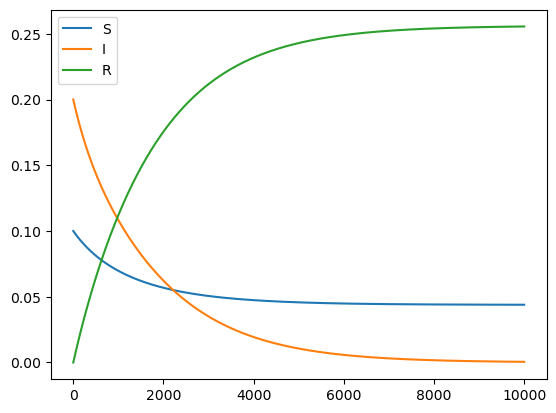

In [18]:
results_test = ode_solver_train(10000)
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(results_test_np[:,0])
plt.plot(results_test_np[:,1])
plt.plot(results_test_np[:,2])

plt.legend(["S", "I", "R"])

plt.show()

# Mean Squared Error Loss - Train set (nt = 1000)

In [19]:
loss = torch.nn.MSELoss()
loss(ode_solver(1000),ode_solver_train(1000))

tensor(0.0002, grad_fn=<MseLossBackward>)

# Mean Squared Error Loss - (nt = 2000)

In [20]:
loss = torch.nn.MSELoss()
loss(ode_solver(2000),ode_solver_train(2000))

tensor(0.0003, grad_fn=<MseLossBackward>)

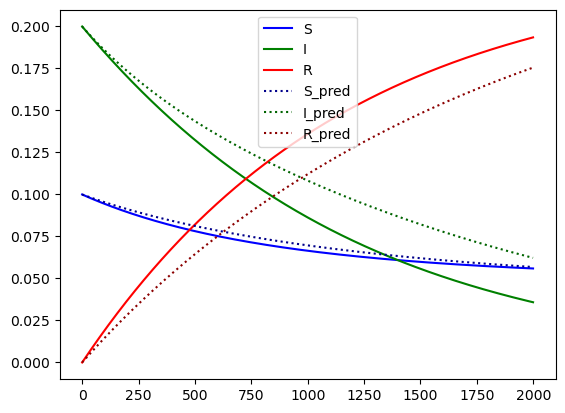

In [21]:
results_test = ode_solver(2000)
results_test_np = results_test.detach().numpy() # Convert to numpy array

results_preds = ode_solver_train(2000)
results_preds_np = results_preds.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(results_test_np[:,0], "b")
plt.plot(results_test_np[:,1], "g")
plt.plot(results_test_np[:,2], "r")

# 2D pred plots
plt.plot(results_preds_np[:,0], "darkblue", linestyle="dotted")
plt.plot(results_preds_np[:,1], "darkgreen", linestyle="dotted")
plt.plot(results_preds_np[:,2], "darkred", linestyle="dotted")

plt.legend(["S", "I", "R", "S_pred", "I_pred", "R_pred"])

plt.show()